In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Statistics
import statsmodels.api as sm

# Machine Learning
from sklearn.metrics import mean_squared_error, r2_score

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Loggers
import logging
logging.getLogger().setLevel(logging.ERROR)

In [3]:
# Get the data
# see the dataset in the lab directory
df = pd.read_csv('medium_posts.csv', usecols=['published', 'url'])
print(df.shape)
df.head()

(155681, 2)


,url,published
0,https://towardsdatascience.com/making-python-p...,1/1/2020
1,https://towardsdatascience.com/how-to-be-fancy...,1/1/2020
2,https://uxdesign.cc/how-exactly-do-you-find-in...,1/1/2020
3,https://towardsdatascience.com/from-scratch-to...,1/1/2020
4,https://www.cantorsparadise.com/the-waiting-pa...,1/1/2020


In [4]:
df.duplicated().sum()

7

In [5]:
# Clean the data
df_cleaned = df.drop_duplicates()

df_cleaned['published'] = pd.to_datetime(df_cleaned['published'])

print(df_cleaned.shape)
df_cleaned.head()

(155674, 2)


,url,published
0,https://towardsdatascience.com/making-python-p...,2020-01-01
1,https://towardsdatascience.com/how-to-be-fancy...,2020-01-01
2,https://uxdesign.cc/how-exactly-do-you-find-in...,2020-01-01
3,https://towardsdatascience.com/from-scratch-to...,2020-01-01
4,https://www.cantorsparadise.com/the-waiting-pa...,2020-01-01


In [6]:
# Set up the data as the number of papers each day after 2019-12-31
df_pr = df_cleaned[df_cleaned.published>'2019-12-31']
df_pr.sort_values('published', inplace=True)
df_pr.set_index('published', inplace=True)
df_pr.head()
daily = df_pr.resample('D').count()
print(daily.shape)
daily.head()

(731, 1)


,url
published,
2020-01-01,205
2020-01-02,306
2020-01-03,274
2020-01-04,147
2020-01-05,206


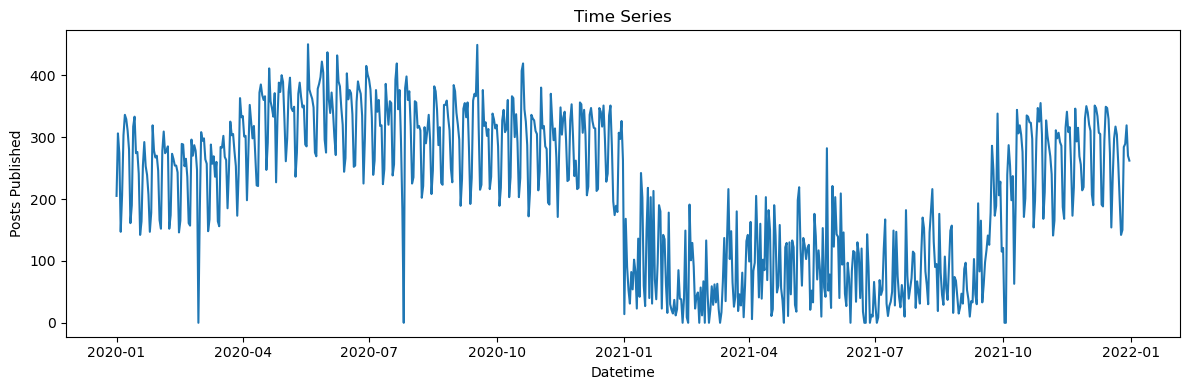

In [12]:
daily = daily.loc['2020-01-01':]
# The time series dataset plot
plt.figure(figsize=(12, 4))
plt.plot(daily)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

            url
published      
2021-01-01   14
2021-01-02  168
2021-01-03   90
2021-01-04   53
2021-01-05   31
...         ...
2021-12-27  284
2021-12-28  289
2021-12-29  319
2021-12-30  270
2021-12-31  262

[365 rows x 1 columns]


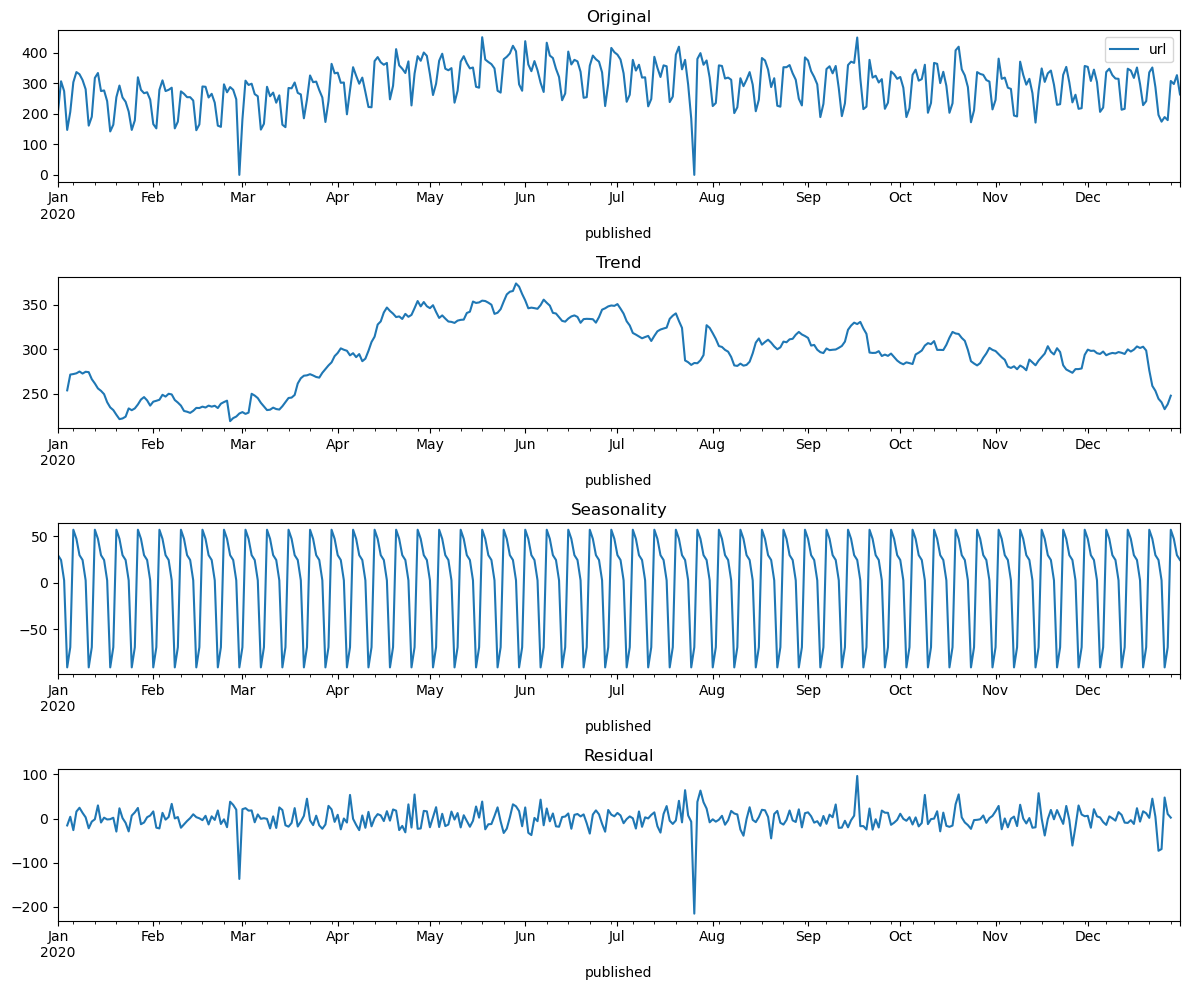

In [11]:
train = daily.loc[:'2020-12-31']
valid = daily.loc['2021-01-01':]

# Let's take some interesting stats from this time series data - trand, seasonality and noise.
decomposition = sm.tsa.seasonal_decompose(train)
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

In [13]:
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train, label='Training')
    plt.plot(valid, label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model} (R^2: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
# the feature set preparation step

def prepare_feature_based_dataset(data, lag_start=5, lag_end=20):
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    # add lags of the input time serial as features
    lag_cols = []
    for i in range(lag_start, lag_end):
        lag_cols.append("lag_{}".format(i))
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # add features
    data["lags_mean"] = data[lag_cols].mean(axis = 1)
    data["lags_median"] = data[lag_cols].median(axis = 1)
    data["lags_max"] = data[lag_cols].max(axis = 1)
    data["lags_min"] = data[lag_cols].min(axis = 1)
    
    data["month"] = data.index.month
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    data = data.dropna()
    X_train = data.loc[:'2020-12-31'].drop(["y"], axis=1)
    y_train = data.loc[:'2020-12-31']["y"]
    X_test = data.loc['2021-01-01':].drop(["y"], axis=1)
    y_test = data.loc['2021-01-01':]["y"]

    return X_train, X_test, y_train, y_test

# Linear regression training

In [15]:
# Let's take lags from 24 to 48, e.g. the model can make a forekast for 24 time periods
X_train, X_valid, y_train, y_valid =  prepare_feature_based_dataset(daily,24,48)

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_valid)

In [18]:
lin_reg_rmse_24_48 = mean_squared_error(y_valid, prediction, squared=False)
lin_reg_r2_24_48 = r2_score(y_valid, prediction)

In [19]:
forecast = pd.Series(prediction)
forecast.index = valid.index

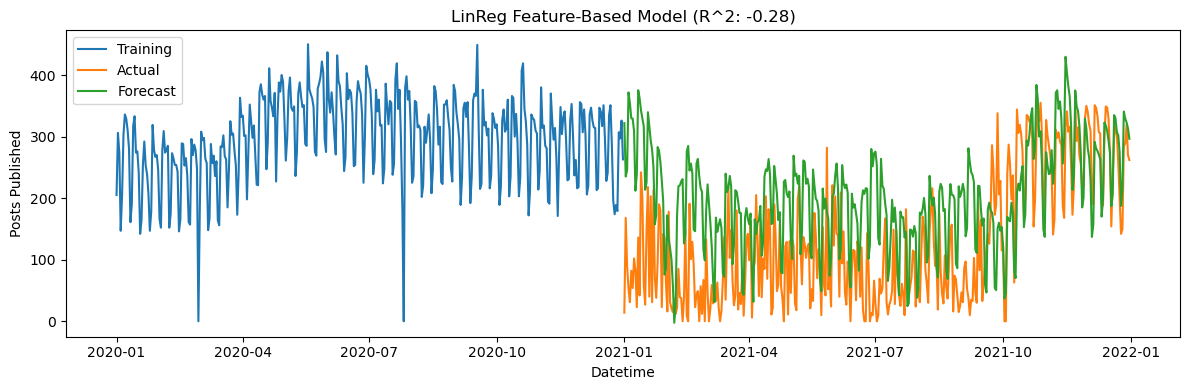

In [20]:
# Plotting the forecast
plot_forecast(forecast, 'LinReg Feature-Based Model', lin_reg_r2_24_48)

In [21]:
# Let's take lags from 1 to 15, e.g. the model can make a forekast for 1 time periods
X_train, X_valid, y_train, y_valid =  prepare_feature_based_dataset(daily,1,15)

In [22]:
lr_15 = LinearRegression()
lr_15.fit(X_train, y_train)
prediction = lr_15.predict(X_valid)

In [23]:
lin_reg_rmse_1_15 = mean_squared_error(y_valid, prediction, squared=False)
lin_reg_r2_1_15 = r2_score(y_valid, prediction)

In [24]:
forecast = pd.Series(prediction)
forecast.index = valid.index

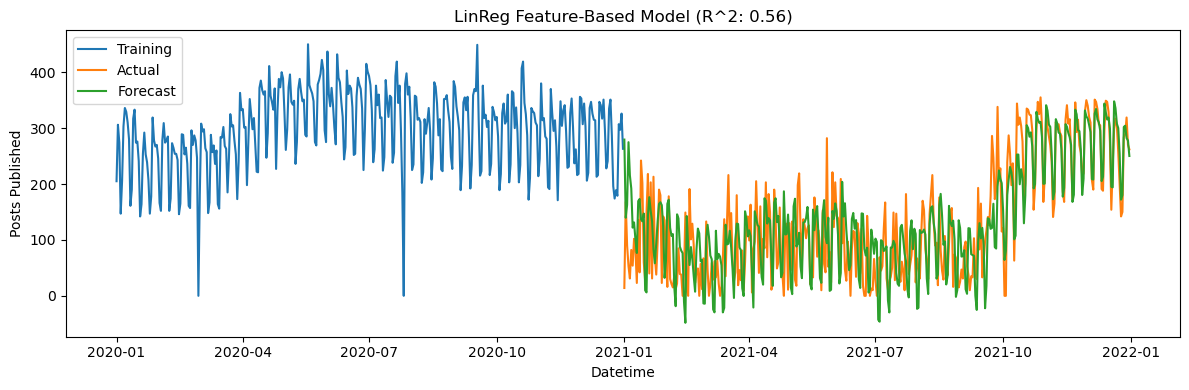

In [25]:
# Plotting the forecast
plot_forecast(forecast, 'LinReg Feature-Based Model', lin_reg_r2_1_15)

In [26]:
# Let's take lags from 48 to 96, e.g. the model can make a forekast for 48 time periods
X_train, X_valid, y_train, y_valid =  prepare_feature_based_dataset(daily,48,96)

In [27]:
lr_48 = LinearRegression()
lr_48.fit(X_train, y_train)
prediction = lr_48.predict(X_valid)

In [28]:
lin_reg_rmse_48_96 = mean_squared_error(y_valid, prediction, squared=False)
lin_reg_r2_48_96 = r2_score(y_valid, prediction)

In [29]:
forecast = pd.Series(prediction)
forecast.index = valid.index

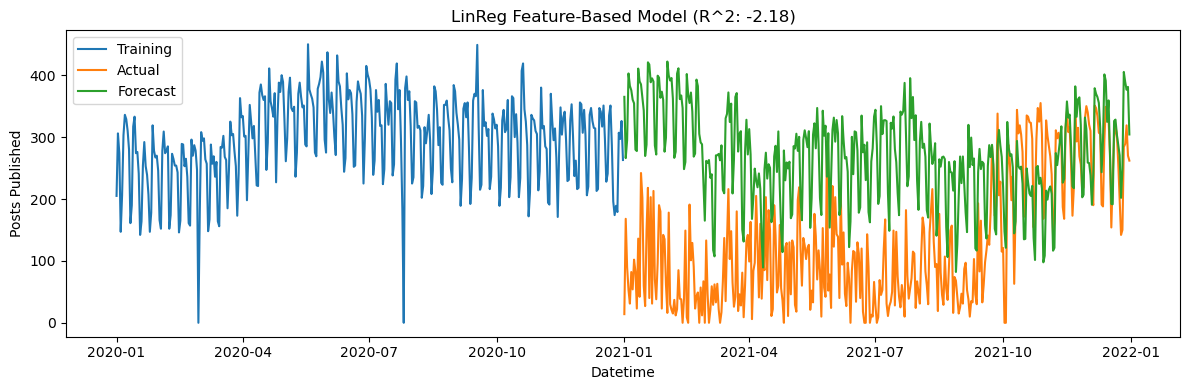

In [30]:
# Plotting the forecast
plot_forecast(forecast, 'LinReg Feature-Based Model', lin_reg_r2_48_96)

# Linear regression models comparison

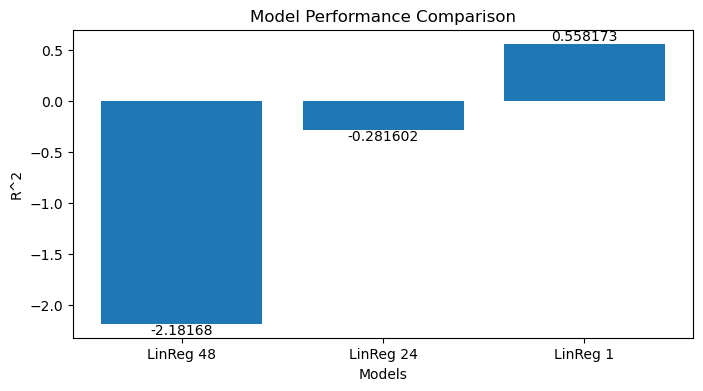

In [32]:
# Comparing Model Performances
perf = pd.DataFrame({'Model': ['LinReg 24','LinReg 1','LinReg 48'],
                     'R2': [lin_reg_r2_24_48, lin_reg_r2_1_15, lin_reg_r2_48_96]})
perf.sort_values('R2', inplace=True)

# Plotting model performances
plt.figure(figsize=(8, 4))
vbar = plt.bar(perf.Model, perf.R2)
plt.bar_label(vbar)
plt.xlabel('Models')
plt.ylabel('R^2')
plt.title('Model Performance Comparison')
plt.show()